In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [ ]:
ruta_archivo = '/content/registros_reparables_motores.xlsx'

# Cargar el archivo Excel en un DataFrame
registros_reparables = pd.read_excel(ruta_archivo, sheet_name='Data filtrada')

In [ ]:
print(registros_reparables)

        OT                     GERENCIA                    SUPERINTENDENCIA  \
0       63  Gerencia Tranques y Relaves  Superintendencia Recursos Hidricos   
1       67  Gerencia Tranques y Relaves  Superintendencia Recursos Hidricos   
2       68  Gerencia Tranques y Relaves  Superintendencia Recursos Hidricos   
3       69  Gerencia Tranques y Relaves  Superintendencia Recursos Hidricos   
4       75           Gerencia Fundición   Superintendencia de Mantenimiento   
...    ...                          ...                                 ...   
1133  2084           Gerencia Fundición   Superintendencia de Mantenimiento   
1134  2086             Gerencia Plantas    Superintendencia Procesos Sewell   
1135  2087             Gerencia Plantas    Superintendencia Procesos Sewell   
1136  2088             Gerencia Plantas    Superintendencia Procesos Sewell   
1137  2090             Gerencia Plantas   Superintendencia de Mantenimiento   

                                     CONTACTO DE RE

In [ ]:
conteos = registros_reparables['VOLTAJE (Volts)'].value_counts()
print(conteos)

VOLTAJE (Volts)
575    965
550    172
578      1
Name: count, dtype: int64


In [ ]:
len(registros_reparables)

1138

In [ ]:
def determinar_polos_frecuencia(rpm):
    rangos_60hz = {
        3600: (2, 60),
        1800: (4, 60),
        1200: (6, 60),
        900: (8, 60),
        720: (10, 60),
        600: (12, 60),
        514: (14, 60),
        450: (16, 60),
        400: (18, 60),
        360: (20, 60),
        327: (22, 60),
        300: (24, 60)
    }
    rangos_50hz = {
        3000: (2, 50),
        1500: (4, 50),
        1000: (6, 50),
        750: (8, 50),
        600: (10, 50),
        500: (12, 50),
        428: (14, 50),
        375: (16, 50),
        333: (18, 50),
        300: (20, 50)
    }

    def buscar_valor_mas_cercano(rpm, rangos):
        # Buscar el valor más cercano superior
        valor_mas_cercano = None
        for valor_rpm in sorted(rangos.keys()):
            if rpm <= valor_rpm:
                valor_mas_cercano = valor_rpm
                break
        if valor_mas_cercano is not None:
            return rangos[valor_mas_cercano]
        return (None, None)

    # Buscar el valor más cercano para 60 Hz
    resultado_60hz = buscar_valor_mas_cercano(rpm, rangos_60hz)

    # Buscar el valor más cercano para 50 Hz
    resultado_50hz = buscar_valor_mas_cercano(rpm, rangos_50hz)

    # Elegir el resultado que tenga la menor diferencia de RPM
    if resultado_50hz[0] is not None and resultado_60hz[0] is not None:
        diff_50hz = abs(rpm - next(val for val in sorted(rangos_50hz.keys()) if rpm <= val))
        diff_60hz = abs(rpm - next(val for val in sorted(rangos_60hz.keys()) if rpm <= val))

        if diff_50hz < diff_60hz:
            return resultado_50hz
        else:
            return resultado_60hz
    elif resultado_50hz[0] is not None:
        return resultado_50hz
    elif resultado_60hz[0] is not None:
        return resultado_60hz
    else:
        return (None, None)

In [ ]:
# Aplicar la función para determinar polos y frecuencia
registros_reparables['Polos'], registros_reparables['Frecuencia'] = zip(*registros_reparables['VELOCIDAD (RPM)'].apply(determinar_polos_frecuencia))

In [ ]:
conteos = registros_reparables['Polos'].value_counts()
print(conteos)

Polos
4.0     813
6.0     129
2.0      67
8.0      63
14.0     42
12.0      9
18.0      5
16.0      5
10.0      1
Name: count, dtype: int64


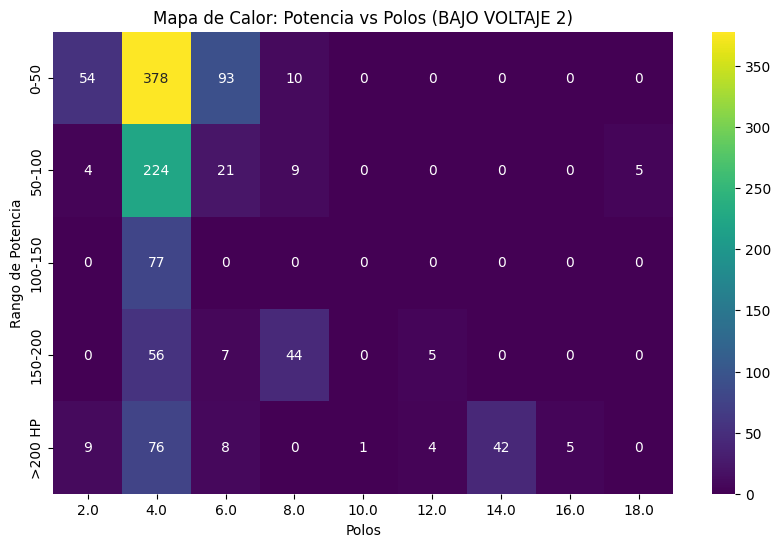

In [ ]:
# Crear bins para la potencia
bins = [0, 50, 100, 150, 200, float('inf')]
labels = ['0-50', '50-100', '100-150', '150-200', '>200 HP']

# Usar .loc para evitar el SettingWithCopyWarning
registros_reparables.loc[:, 'Rango_Potencia'] = pd.cut(registros_reparables['POTENCIA (HP)'], bins=bins, labels=labels, include_lowest=True)

# Crear una tabla pivote para el mapa de calor, especificando observed=False
heatmap_data = registros_reparables.pivot_table(index='Rango_Potencia', columns='Polos', values='POTENCIA (HP)', aggfunc='count', observed=False)

# Crear el mapa de calor
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="viridis")
plt.title('Mapa de Calor: Potencia vs Polos (BAJO VOLTAJE 2)')
plt.xlabel('Polos')
plt.ylabel('Rango de Potencia')
plt.show()

In [ ]:
registros_reparables2 = registros_reparables[
    (registros_reparables['POTENCIA (HP)'] <= 100) &
    (registros_reparables['Polos'] == 4)
]

In [ ]:
len(registros_reparables2)

602

In [ ]:
# Contar valores faltantes en las columnas especificadas
missing_values = registros_reparables2[['POTENCIA (HP)', 'VOLTAJE (Volts)', 'VELOCIDAD (RPM)', 'MARCA']].isnull().sum()
missing_values

,0
POTENCIA (HP),0
VOLTAJE (Volts),0
VELOCIDAD (RPM),0
MARCA,111


In [ ]:
registros_reparables['FECHA ENTREGA FAENA'] = pd.to_datetime(registros_reparables['FECHA ENTREGA FAENA'], errors='coerce')
registros_reparables['FECHA REQUERIMIENTO'] = pd.to_datetime(registros_reparables['FECHA REQUERIMIENTO'], errors='coerce')
registros_reparables['FECHA RECEPCIONADO'] = pd.to_datetime(registros_reparables['FECHA RECEPCIONADO'], errors='coerce')


In [ ]:

nat_counts = registros_reparables[['FECHA ENTREGA FAENA', 'FECHA REQUERIMIENTO', 'FECHA RECEPCIONADO']].isna().sum()
nat_counts

,0
FECHA ENTREGA FAENA,780
FECHA REQUERIMIENTO,0
FECHA RECEPCIONADO,719


In [ ]:
# Cantidad de registros con "Sin datos" en la columna 'TIPO REPARACIÓN'
sin_datos_count = registros_reparables[registros_reparables['TIPO REPARACIÓN'] == 'Sin datos']['TIPO REPARACIÓN'].count()

print(f'Cantidad de registros con TIPO REPARACIÓN "Sin datos": {sin_datos_count}')
# Cantidad de registros vacíos en la columna 'TIPO REPARACIÓN'
empty_tipo_reparacion = registros_reparables['TIPO REPARACIÓN'].isnull().sum()
print(f"Cantidad de registros vacíos en 'TIPO REPARACIÓN': {empty_tipo_reparacion}")


Cantidad de registros con TIPO REPARACIÓN "Sin datos": 87
Cantidad de registros vacíos en 'TIPO REPARACIÓN': 0


In [ ]:
# prompt: ESTADISTICAS DE COLUMNAS 'POTENCIA (HP)', 'VOLTAJE (Volts)', 'VELOCIDAD (RPM)', 'MARCA'DE REGISTROS_REPARABLES

# Mostrar estadísticas descriptivas para las columnas especificadas
estadisticas = registros_reparables2[['POTENCIA (HP)', 'VOLTAJE (Volts)', 'VELOCIDAD (RPM)']].describe()
print(estadisticas)

# Mostrar la frecuencia de cada valor único en la columna 'MARCA'
frecuencia_marca = registros_reparables2['MARCA'].value_counts()
frecuencia_marca

       POTENCIA (HP)  VOLTAJE (Volts)  VELOCIDAD (RPM)
count     602.000000       602.000000       602.000000
mean       45.029236       572.549834      1492.380399
std        36.220915         7.439272        87.071718
min         0.100000       550.000000      1310.000000
25%        10.000000       575.000000      1460.000000
50%        30.000000       575.000000      1478.000000
75%        75.000000       575.000000      1485.000000
max       100.000000       575.000000      1800.000000


,count
MARCA,
WEG,168
RELIANCE,94
ABB,58
SIEMENS,28
EURODRIVE,21
BALDOR,20
ELECTRICAL,20
GE,13
GEVISA,10


In [ ]:
# Contar la cantidad de veces que aparece cada valor en la columna "TIPO REPARACIÓN"
tipo_reparacion_counts = registros_reparables['TIPO REPARACIÓN'].value_counts()

tipo_reparacion_counts

,count
TIPO REPARACIÓN,
Sin datos,87
2 Mantención correctiva motores jaula ardilla clase de aislación H,85
83 Mantención preventiva motores jaula ardilla,60
65 Mantención correctiva motores jaula ardilla clase de aislación H,51
122 Mantención preventiva motores jaula ardilla,41
...,...
1209 Mantención preventiva motores de inducción 750-1000 RPM,1
1.1 Mantención preventiva motores de inducción 750-1000 RPM,1
1788 Encamisado de Tapa de Alojamiento de Rodamientos,1


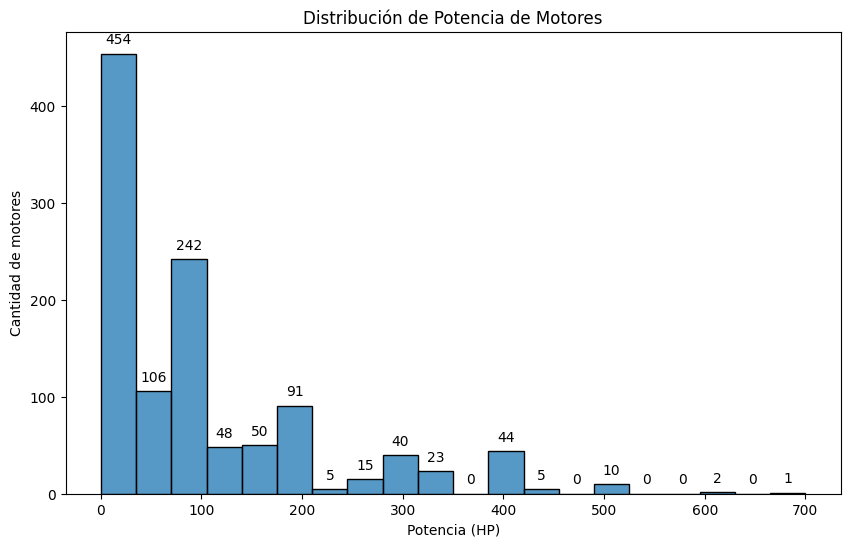

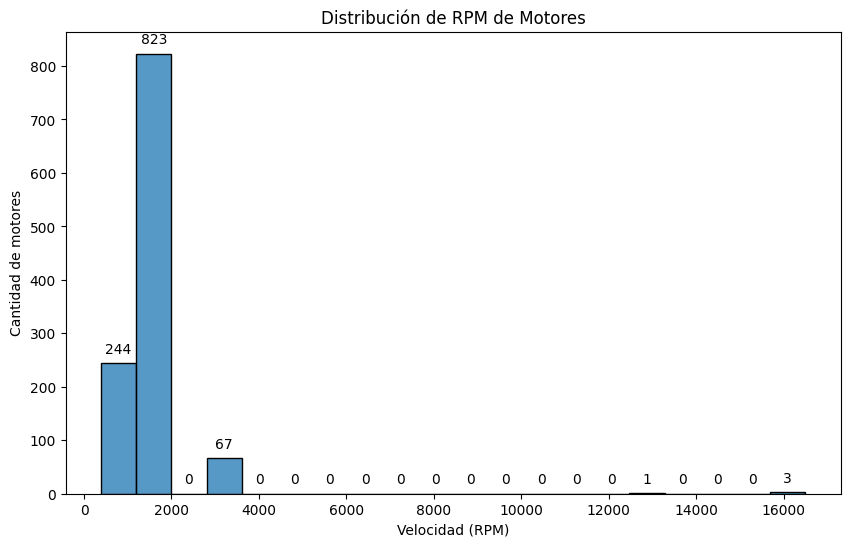

In [ ]:

# Gráfico de distribución de Potencia (HP) con cantidades en las barras
plt.figure(figsize=(10, 6))
sns.histplot(registros_reparables['POTENCIA (HP)'], kde=False, bins=20)  # Ajusta el número de bins según sea necesario
plt.xlabel('Potencia (HP)')
plt.ylabel('Cantidad de motores')
plt.title('Distribución de Potencia de Motores')

# Agregar las cantidades encima de las barras
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

# Gráfico de distribución de RPM con cantidades en las barras
plt.figure(figsize=(10, 6))
sns.histplot(registros_reparables['VELOCIDAD (RPM)'], kde=False, bins=20)  # Ajusta el número de bins según sea necesario
plt.xlabel('Velocidad (RPM)')
plt.ylabel('Cantidad de motores')
plt.title('Distribución de RPM de Motores')

# Agregar las cantidades encima de las barras
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

In [ ]:
registros_reparables2['Potencia_RPM'] = (
    'MOTOR DE ' + registros_reparables['POTENCIA (HP)'].astype(str) + 'HP, ' +
    registros_reparables['VELOCIDAD (RPM)'].astype(str) + 'RPM ' + 'y de ' +
    registros_reparables['VOLTAJE (Volts)'].astype(str) + 'V'
)


<ipython-input-27-2e4fcedf6e8a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  registros_reparables2['Potencia_RPM'] = (


In [ ]:

# Contar la frecuencia de cada valor único en la columna 'Potencia_RPM'
conteo_potencia_rpm = registros_reparables2['Potencia_RPM'].value_counts()
conteo_potencia_rpm

,count
Potencia_RPM,
"MOTOR DE 100.0HP, 1485RPM y de 575V",54
"MOTOR DE 100.0HP, 1480RPM y de 575V",32
"MOTOR DE 75.0HP, 1470RPM y de 575V",28
"MOTOR DE 15.0HP, 1450RPM y de 575V",22
"MOTOR DE 100.0HP, 1500RPM y de 575V",22
...,...
"MOTOR DE 60.0HP, 1478RPM y de 575V",1
"MOTOR DE 15.0HP, 1475RPM y de 575V",1
"MOTOR DE 15.0HP, 1465RPM y de 575V",1


In [ ]:
print(registros_reparables2)

        OT            GERENCIA                   SUPERINTENDENCIA  \
6       84  Gerencia Fundición  Superintendencia de Mantenimiento   
7       85  Gerencia Fundición  Superintendencia de Mantenimiento   
8       86  Gerencia Fundición  Superintendencia de Mantenimiento   
9       87  Gerencia Fundición  Superintendencia de Mantenimiento   
18     101  Gerencia Fundición  Superintendencia de Mantenimiento   
...    ...                 ...                                ...   
1127  2078    Gerencia Plantas  Superintendencia de Mantenimiento   
1128  2079    Gerencia Plantas  Superintendencia de Mantenimiento   
1130  2081    Gerencia Plantas  Superintendencia de Mantenimiento   
1131  2082    Gerencia Plantas  Superintendencia de Mantenimiento   
1132  2083    Gerencia Plantas  Superintendencia de Mantenimiento   

                                    CONTACTO DE RETIRO  \
6     Maldonado Ampuero Pedro Pablo (Codelco-Teniente)   
7     Maldonado Ampuero Pedro Pablo (Codelco-Teniente) 

In [ ]:
# prompt: descargar registros reparables 2

# Descargar el archivo 'registros_reparables2.xlsx'
from google.colab import files
registros_reparables2.to_excel('registros_reparables2.xlsx', index=False)
files.download('registros_reparables2.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>